<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-30 18:57:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-05-30 18:57:58 (320 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



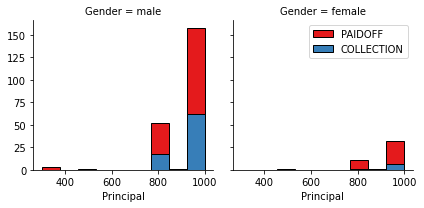

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

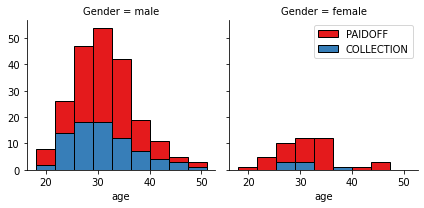

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


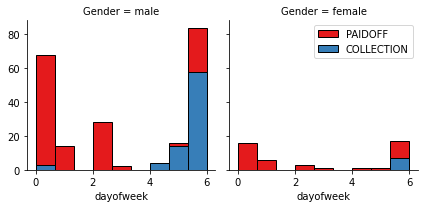

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [21]:
# What k value to use? Lets calculate and graph accuracy rate for values of k up to 20
accuracy_rate = [] # we will append to this in the loop
actual_values = y_test
for k in range(1,21): # from 1 to 20
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    predicted_values = knn_model.predict(X_test)
    # Actual values are stored in y_test, while predicted_values contains the predicted values using the model initialized with each iteration of k
    accuracy = (predicted_values==actual_values) # Returns array of bool where len(error_rate) = len(predicted_values) = len(actual_values)
    # Elements within accuracy reflect whether each corresponding elements in actual and predicted values are same (true) or not same (false)
    accuracy_rate.append(np.mean(accuracy)) # can take mean of bool array since true = 1 and false = 0
    # If accuracy rate is closer to 1 it means most of the predicted values and actual values were the same, if near 0 they were different

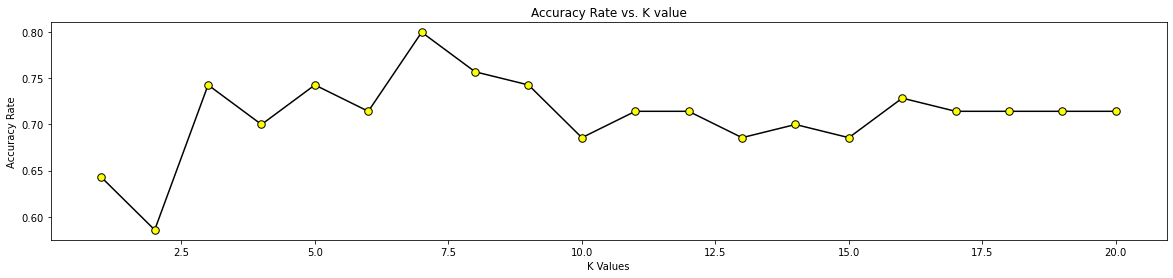

The best accuracy rate was: 0.8 with k =  7


In [22]:
# lets graph the accuracy_rate with each number of k
plt.figure(figsize=(20,4))
plt.plot(range(1,21), accuracy_rate, marker='.', color='black', markerfacecolor='yellow', markersize=15)
plt.title('Accuracy Rate vs. K value')
plt.xlabel('K Values')
plt.ylabel('Accuracy Rate')
plt.show()
print('The best accuracy rate was:', max(accuracy_rate), 'with k = ', accuracy_rate.index(max(accuracy_rate))+1)

In [23]:
# According to the graph, k value of 7 is ideal
knn_m = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
pred_v = knn_m.predict(X_test)

# Now lets display the confusion matrix, classification report and accuracy score from metrics
print(f"Confusion Matrix: \n \n {metrics.confusion_matrix(pred_v, y_test)}\n \n")
print(f"Classification Report: \n \n{metrics.classification_report(pred_v,y_test)}\n\n")
print(f"Accuracy score: \n \n{metrics.accuracy_score(pred_v,y_test)}\n\n")
print(f"Self calculated Accuracy score: \n\n{accuracy_rate[6]}") # Same as the one calculated using metrics

print("F1 Score: ", metrics.f1_score(y_test, pred_v, average='weighted'))
print("Jaccard Score: ", metrics.jaccard_score(y_test, pred_v, pos_label='PAIDOFF'))

Confusion Matrix: 
 
 [[ 8  7]
 [ 7 48]]
 

Classification Report: 
 
              precision    recall  f1-score   support

  COLLECTION       0.53      0.53      0.53        15
     PAIDOFF       0.87      0.87      0.87        55

    accuracy                           0.80        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.80      0.80      0.80        70



Accuracy score: 
 
0.8


Self calculated Accuracy score: 

0.8
F1 Score:  0.8
Jaccard Score:  0.7741935483870968


# Decision Tree


In [24]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
dtm = DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(X_train,y_train)
pred_dtm = dtm.predict(X_test)
print('Decision Tree accuracy: ', metrics.accuracy_score(y_test, pred_dtm))

Decision Tree accuracy:  0.7714285714285715


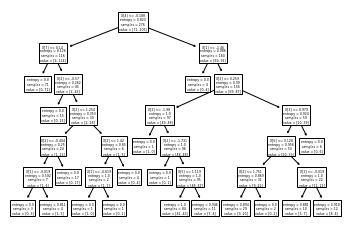

In [25]:
sklearn.tree.plot_tree(dtm)
plt.show()

In [26]:
print(f"Confusion Matrix: \n \n {metrics.confusion_matrix(pred_dtm, y_test)}\n \n")
print(f"Classification Report: \n \n{metrics.classification_report(pred_dtm,y_test)}\n\n")
print(f"Accuracy score: \n \n{metrics.accuracy_score(pred_dtm,y_test)}\n\n")

print("F1 Score: ", metrics.f1_score(y_test, pred_dtm, average='weighted'))
print("Jaccard Score: ", metrics.jaccard_score(y_test, pred_dtm, pos_label='PAIDOFF'))

Confusion Matrix: 
 
 [[ 1  2]
 [14 53]]
 

Classification Report: 
 
              precision    recall  f1-score   support

  COLLECTION       0.07      0.33      0.11         3
     PAIDOFF       0.96      0.79      0.87        67

    accuracy                           0.77        70
   macro avg       0.52      0.56      0.49        70
weighted avg       0.93      0.77      0.84        70



Accuracy score: 
 
0.7714285714285715


F1 Score:  0.7064793130366899
Jaccard Score:  0.7681159420289855


# Support Vector Machine


In [27]:
from sklearn.svm import SVC
svcM = SVC(kernel='rbf', degree=3).fit(X_train,y_train)
pred_svcM = svcM.predict(X_test)
pred_svcM[:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [28]:
print(f"Confusion Matrix: \n\n {metrics.confusion_matrix(pred_svcM, y_test)}\n\n")

Confusion Matrix: 

 [[ 4  7]
 [11 48]]




In [29]:
print(f"Classification Report: \n\n{metrics.classification_report(pred_svcM,y_test)}\n\n")
print(f"Accuracy score: \n\n{metrics.accuracy_score(pred_svcM,y_test)}\n\n")

print("F1 Score: ", metrics.f1_score(y_test, pred_svcM, average='weighted'))
print("Jaccard Score: ", metrics.jaccard_score(y_test, pred_svcM, pos_label='PAIDOFF'))

Classification Report: 

              precision    recall  f1-score   support

  COLLECTION       0.27      0.36      0.31        11
     PAIDOFF       0.87      0.81      0.84        59

    accuracy                           0.74        70
   macro avg       0.57      0.59      0.57        70
weighted avg       0.78      0.74      0.76        70



Accuracy score: 

0.7428571428571429


F1 Score:  0.7275882012724117
Jaccard Score:  0.7272727272727273


# Logistic Regression


In [30]:
from sklearn.linear_model import LogisticRegression
lrm= LogisticRegression(solver='liblinear', C=0.01).fit(X_train,y_train)

In [31]:
pred_lrm = lrm.predict(X_test)
pred_lrm_prob = lrm.predict_proba(X_test)

In [32]:
print(f"Confusion Matrix: \n\n {metrics.confusion_matrix(pred_lrm, y_test)}\n\n")
print(f"Classification Report: \n\n{metrics.classification_report(pred_lrm,y_test)}\n\n")
print(f"Accuracy score: \n\n{metrics.accuracy_score(pred_lrm,y_test)}\n\n")

print("F1 Score: ", metrics.f1_score(y_test, pred_lrm, average='weighted'))
print("Jaccard Score: ", metrics.jaccard_score(y_test, pred_lrm, pos_label='PAIDOFF'))

Confusion Matrix: 

 [[ 2  9]
 [13 46]]


Classification Report: 

              precision    recall  f1-score   support

  COLLECTION       0.13      0.18      0.15        11
     PAIDOFF       0.84      0.78      0.81        59

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.73      0.69      0.70        70



Accuracy score: 

0.6857142857142857


F1 Score:  0.6670522459996144
Jaccard Score:  0.6764705882352942


# Model Evaluation using Test set


In [33]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-30 18:58:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-30 18:58:09 (104 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
test_df.groupby(["Gender"])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [37]:
test_df.dtypes # due_date and effective_date are object type instead of date

Unnamed: 0.1       int64
Unnamed: 0         int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [38]:
# Convert due_date and effective_date columns into datetime types
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Make new day of week column
test_df['day_of_week'] = test_df['effective_date'].dt.dayofweek

# Make new column containing 1 if day of week is more than 3, else 0
test_df['end_of_week'] = test_df['day_of_week'].apply(lambda x: 1 if (x>3) else 0)

# Modify Gender column to contain 1 if male and 0 if female
test_df['Gender'] = test_df['Gender'].replace(['male', 'female'], [0,1])

# Create dummy columns for education
test_feature = test_df[['Principal','terms','age','Gender','end_of_week']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Normalize features
test_fX = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)

# Set target
test_tY = test_df['loan_status'].values

In [39]:
# Evaluate all 4 models
knn_pred = knn_m.predict(test_fX)
dt_pred = dtm.predict(test_fX)
svc_pred = svcM.predict(test_fX)
lr_pred = lrm.predict(test_fX)

# Calculate jaccard score for all models and store it in list to later add to table
jsK = jaccard_score(test_tY, knn_pred, pos_label='PAIDOFF')
jsD = jaccard_score(test_tY, dt_pred, pos_label='PAIDOFF')
jsS = jaccard_score(test_tY, svc_pred, pos_label='PAIDOFF')
jsL = jaccard_score(test_tY, lr_pred, pos_label='PAIDOFF')
js_list = [jsK,jsD,jsS,jsL]

# Same thing for F1 score
fsK = f1_score(test_tY, knn_pred, average='weighted')
fsD = f1_score(test_tY, dt_pred, average='weighted')
fsS = f1_score(test_tY, svc_pred, average='weighted')
fsL = f1_score(test_tY, lr_pred, average='weighted')
fs_list = [fsK,fsD,fsS,fsL]

print("KNN F1 Score: ", metrics.f1_score(test_tY, knn_pred, average='weighted'))
print("KNN Jaccard Score: ", metrics.jaccard_score(test_tY, knn_pred, pos_label='PAIDOFF'))

print("Decision Tree F1 Score: ", metrics.f1_score(test_tY, dt_pred, average='weighted'))
print("Decision Tree Jaccard Score: ", metrics.jaccard_score(test_tY, dt_pred, pos_label='PAIDOFF'))

print("SVM F1 Score: ", metrics.f1_score(test_tY, svc_pred, average='weighted'))
print("SVM Jaccard Score: ", metrics.jaccard_score(test_tY, svc_pred, pos_label='PAIDOFF'))

print("Logistic Regression F1 Score: ", metrics.f1_score(test_tY, lr_pred, average='weighted'))
print("Logistic Regression Jaccard Score: ", metrics.jaccard_score(test_tY, lr_pred, pos_label='PAIDOFF'))

KNN F1 Score:  0.6602254428341383
KNN Jaccard Score:  0.6666666666666666
Decision Tree F1 Score:  0.6704776923582364
Decision Tree Jaccard Score:  0.7115384615384616
SVM F1 Score:  0.7583503077293734
SVM Jaccard Score:  0.78
Logistic Regression F1 Score:  0.6604267310789049
Logistic Regression Jaccard Score:  0.7358490566037735


In [40]:
# Calculating Log Loss for Logistic Regression Model
yhat_prob = lrm.predict_proba(test_fX)
# Creating a list to append to table, everything except logistic regression gets a log_loss value, else NA
lLoss_list = ['NA','NA','NA',log_loss(test_tY,yhat_prob)]
lLoss_list

['NA', 'NA', 'NA', 0.5672153379912981]

In [41]:
# Making Report Table

report_df = pd.DataFrame(index=['KNN','Decision Tree','SVM','Logistic Regression'])
report_df.columns.name = 'Algorithms'
report_df.insert(0, 'Jaccard Score', js_list)
report_df.insert(1, 'F1 Score', fs_list)
report_df.insert(2, 'Log Loss', lLoss_list)
report_df

Algorithms,Jaccard Score,F1 Score,Log Loss
KNN,0.666667,0.660225,NA
Decision Tree,0.711538,0.670478,NA
SVM,0.780000,0.758350,NA
Logistic Regression,0.735849,0.660427,0.567215


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
